# CNN + SIFT

In [33]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

from keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
import time

In [3]:
def get_n_similar(n, counts, reverse):
    sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=reverse)[:n] #Ordeno y me quedo con los 5 más parecidos
    sorted_indexes = [idx[0] for idx in sorted_counts]
    return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)
        

    plt.show()
    
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths

In [4]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601", 
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325", 
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]
len(carpetas)

20

In [5]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

In [6]:
if os.path.exists('./npy_mat/CNN_SIFT.npy'):
    cnn_sift = np.load('./npy_mat/CNN_SIFT.npy')
else:
    # Crear un diccionario para mapear la combinación única de carpeta e índice a las características
    caracteristics_dict = {}
    for row in caracteristics:
        folder, index, *features = row
        caracteristics_dict[(folder, index)] = features

    # Crear una lista para almacenar las filas combinadas
    combined_data = []

    # Especifica el tamaño de lote
    batch_size = 1000

    # Divide 'descriptors' en lotes más pequeños y combina los lotes con 'caracteristics'
    for i in range(0, len(descriptors), batch_size):
        descriptors_batch = descriptors[i:i+batch_size]

        # Combinar 'descriptors_batch' con 'caracteristics' y almacenar en 'combined_data'
        for row in descriptors_batch:
            folder, index, *sift_descriptors = row
            if (folder, index) in caracteristics_dict:
                caracteristic_features = caracteristics_dict[(folder, index)]
                combined_row = [folder, index] + caracteristic_features + sift_descriptors
                combined_data.append(combined_row)

    # Convertir la lista de filas combinadas en un array de NumPy
    cnn_sift = np.save('CNN_SIFT', combined_array)

In [7]:
cnn_sift.shape

(72594, 25218)

In [34]:
n_neighbors = 20
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

cnn_sift_train = cnn_sift[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(cnn_sift_train)

NearestNeighbors(metric='euclidean', n_neighbors=20)

In [35]:
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
sift = cv2.SIFT_create()

# new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
# new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
new_img = cv2.cvtColor(cv2.imread('./dataset/test/coches-/n02814533_199.JPEG'), cv2.COLOR_BGR2RGB)


_ , descriptors = sift.detectAndCompute(new_img, mask=None)

# Redimensionar la imagen al tamaño requerido por el modelo
target_size = (224, 224)
new_img_cnn = cv2.resize(new_img, target_size)
# Agregar una dimensión
new_img_cnn = np.expand_dims(new_img_cnn, axis=0)
# Normalizar la imagen
new_img_cnn = preprocess_input(new_img_cnn)

# Extraer las características de la imagen
caracteristics_img = model.predict(new_img_cnn)
caracteristics_flat = caracteristics_img.reshape(1, -1)


new_shape = (len(descriptors), 25088)
expanded_array = np.repeat(caracteristics_flat, new_shape[0], axis=0)
full_arr = np.hstack((expanded_array, descriptors))






1/1 [==============================] - 1s 501ms/step


In [36]:
counts = {}
tiempo_inicio = time.time()
for cnn_descrp in full_arr:
    cnn_descrp = cnn_descrp.reshape(1, -1)
    _, indice = knn.kneighbors(cnn_descrp, n_neighbors=n_neighbors)
    for idx in indice[0]:
        carpeta = str(int(cnn_sift[idx,0]))
        num_img = str(int(cnn_sift[idx,1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += 1
        else:
            counts[id] = 1
tiempo_fin = time.time()
tiempo_transcurrido = tiempo_fin - tiempo_inicio
print(f"Tiempo de ejecucion: {tiempo_transcurrido} segundos.")

Tiempo de ejecucion: 391.40704131126404 segundos.


In [37]:
len(counts)

33

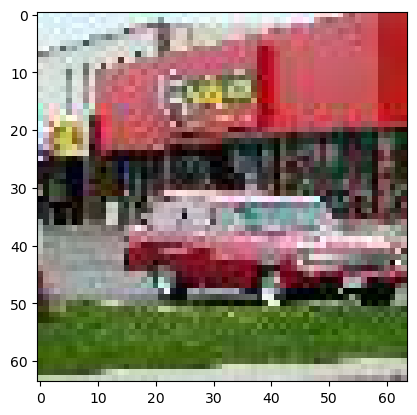

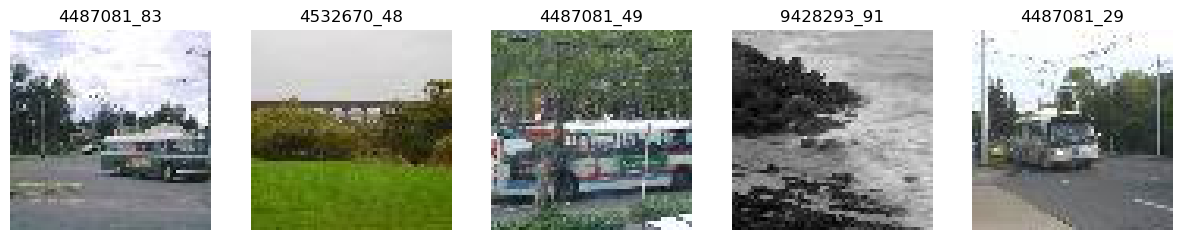

In [41]:
plt.imshow(new_img)
idx_similar = get_n_similar(n_neighbors, counts, 1)
display_n_similar(idx_similar, 5)